<a href="https://colab.research.google.com/github/Anuj-ipynb/Hybrid_System_Optimisation/blob/main/Untitled46.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import gym
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler





In [3]:
class HybridElectricEnv(gym.Env):
    def __init__(self):
        super(HybridElectricEnv, self).__init__()

        self.action_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([1, 1]), dtype=np.float32)
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0]), high=np.array([1, 1, 1]), dtype=np.float32
        )
        self.state = np.random.uniform(0, 1, size=(3,))
        self.noise_reduction_factor = 0.0

    def reset(self):
        self.state = np.random.uniform(0, 1, size=(3,))
        self.noise_reduction_factor = 0.0
        return self.state

    def step(self, action):
        turbine_power, motor_power = action
        vibration = self.state[0] - 0.1 * turbine_power
        noise = self.state[1] - 0.2 * motor_power
        energy_efficiency = self.state[2] + 0.05 * motor_power - 0.03 * turbine_power
        self.state = np.clip([vibration, noise, energy_efficiency], 0, 1)

        reward = (
            -abs(noise - 0.2)
            + energy_efficiency
            - abs(turbine_power + motor_power - 1)
        )

        done = False
        return self.state, reward, done, {}

In [4]:
class PPOAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.actor_model = self.build_actor()
        self.critic_model = self.build_critic()
        self.total_rewards = []

    def build_actor(self):
        inputs = layers.Input(shape=(self.state_size,))
        x = layers.Dense(128, activation="relu")(inputs)
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(self.action_size, activation="sigmoid")(x)
        model = models.Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
        return model

    def build_critic(self):
        inputs = layers.Input(shape=(self.state_size,))
        x = layers.Dense(128, activation="relu")(inputs)
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(1, activation="linear")(x)
        model = models.Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse")
        return model

    def train(self, episodes=20):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(200):
                state = state.reshape(1, -1)
                action = self.actor_model.predict(state, verbose=0)[0]
                action = np.clip(action, 0, 1)

                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                target = reward + 0.99 * self.critic_model.predict(next_state.reshape(1, -1), verbose=0)
                self.critic_model.train_on_batch(state, target)

                with tf.GradientTape() as tape:
                    advantages = target - self.critic_model.predict(state, verbose=0)
                    action_probs = self.actor_model(state, training=True)
                    loss = -tf.reduce_mean(advantages * tf.math.log(action_probs))
                grads = tape.gradient(loss, self.actor_model.trainable_variables)
                self.actor_model.optimizer.apply_gradients(zip(grads, self.actor_model.trainable_variables))

                state = next_state

                if done:
                    break

            self.total_rewards.append(total_reward)
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    def plot_rewards(self):
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=range(1, len(self.total_rewards) + 1), y=self.total_rewards, marker="o")
        plt.title("Total Rewards per Episode", fontsize=16)
        plt.xlabel("Episode", fontsize=14)
        plt.ylabel("Total Reward", fontsize=14)
        plt.grid(True)
        plt.show()

    def predict_new_episode(self):
        state = self.env.reset()
        action = self.actor_model.predict(state.reshape(1, -1), verbose=0)[0]
        action = np.clip(action, 0, 1)
        print(f"Predicted Action for New Episode: {action}")
        next_state, _, _, _ = self.env.step(action)
        print(f"Predicted Next State: {next_state}")
        return next_state


def train_linear_regression_model():
    state_data = np.random.random((1000, 3))
    reward_data = np.random.random(1000)

    scaler = StandardScaler()
    state_data_scaled = scaler.fit_transform(state_data)


    model = LinearRegression()
    model.fit(state_data_scaled, reward_data)


    predictions = model.predict(state_data_scaled)
    mse = mean_squared_error(reward_data, predictions)
    r2 = r2_score(reward_data, predictions)
    evs = explained_variance_score(reward_data, predictions)

    print(f"Linear Regression Model R-squared: {r2:.4f}")
    print(f"Linear Regression Model MSE: {mse:.4f}")
    print(f"Linear Regression Model Explained Variance Score: {evs:.4f}")


    accuracy = evs * 100
    print(f"Linear Regression Model 'Accuracy' (Explained Variance  * 100): {accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


Episode 1, Total Reward: 25.836630580402353
Episode 2, Total Reward: 3.290159193096227
Episode 3, Total Reward: 25.893796171636172
Episode 4, Total Reward: 64.69316914191307
Episode 5, Total Reward: 70.83682283892391
Episode 6, Total Reward: 32.18307107940585
Episode 7, Total Reward: 61.66005495590287
Episode 8, Total Reward: 80.07242614099091
Episode 9, Total Reward: 65.54956843873312
Episode 10, Total Reward: 53.9851656146847
Episode 11, Total Reward: 88.07510074223899
Episode 12, Total Reward: 86.06394050889831
Episode 13, Total Reward: 121.36636513667177
Episode 14, Total Reward: 119.2547459732715
Episode 15, Total Reward: 81.86959479379249
Episode 16, Total Reward: 84.32533944216927
Episode 17, Total Reward: 124.23782584886679
Episode 18, Total Reward: 115.08367865221066
Episode 19, Total Reward: 94.10344342794274
Episode 20, Total Reward: 107.91919293257126


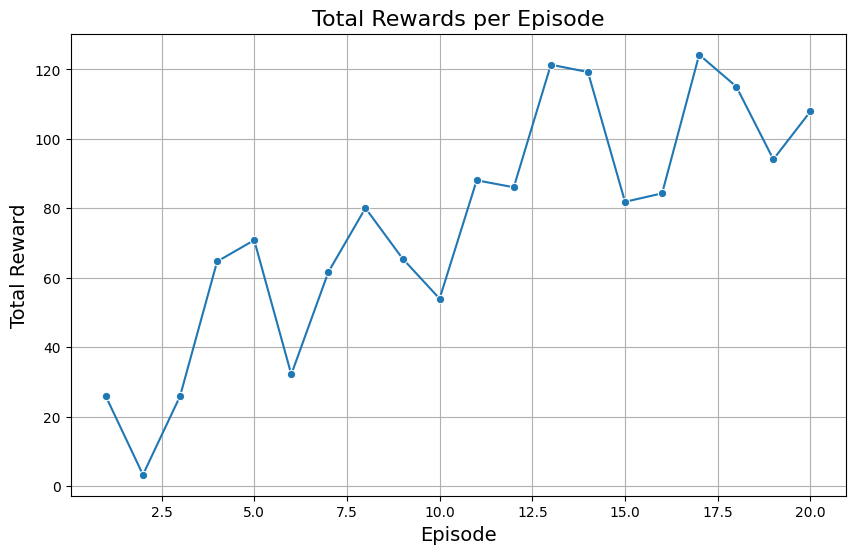

Predicted Action for New Episode: [0.50094426 0.49661088]
Predicted Next State: [0.21656081 0.         0.65977758]
Linear Regression Model R-squared: 0.0037
Linear Regression Model MSE: 0.0780
Linear Regression Model Explained Variance Score: 0.0037
Linear Regression Model 'Accuracy' (Explained Variance  * 100): 0.37%


In [5]:

if __name__ == "__main__":
    env = HybridElectricEnv()
    agent = PPOAgent(env)
    agent.train(episodes=20)
    agent.plot_rewards()
    agent.predict_new_episode()
    train_linear_regression_model()
